In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import os.path

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
# Define helper functions

# Convert folder to dataframe of images' paths & labels
def get_paths_labels(path, allowed_extension="jpg"):
        global Path
        images_dir = Path(path)
        
        filepaths = pd.Series((images_dir.glob(fr'**/*.{allowed_extension}'))).astype(str)
        filepaths.name = "path"
        
        labels = filepaths.str.split("/")[:].str[-2]
        labels.name = "label"

        # Concatenate filepaths and labels
        df = pd.concat([filepaths, labels], axis=1)

        # Shuffle the DataFrame and reset index
        df = df.sample(frac=1).reset_index(drop = True)
        return df

# Read image
def get_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
    
# Visualize samples
def visualize_samples(datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    images = filepaths.apply(get_image).reset_index(drop=True)
    
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(labels[sample_index])
            ax[i,j].set_axis_off()
    plt.show()
    

# Process image (input) for the model
def process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img


# Make classifications & visualize results
def visualize_classifications(model, datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    
    images = filepaths.apply(get_image).reset_index(drop=True)
    processed_images = np.vstack(images.apply(process).to_numpy()[:])
    
    y_pred = classes[np.argmax(model.predict(processed_images, verbose=0), axis=1)]
    y_true = labels
    
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(f"Y true({y_true[sample_index]}) | Y pred ({y_pred[sample_index]})")
            ax[i,j].set_axis_off()
    plt.show()

In [3]:
# Read datasets

# Create dataframe of {paths, labels}
train_df = get_paths_labels('../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train')

# Import another dataset (to train model on various data)
temp_df = get_paths_labels('../input/asl-alphabet-test')

# Combine both datasets
dataset = pd.concat((train_df, temp_df))


In [4]:
# Classes counts
print("Classes counts")
counts = dataset.iloc[:,1].value_counts().sort_index()
print(counts.head(counts.shape[0]))
print(f"\n\nDataset size = {counts.sum()} samples")

Classes counts
A          3060
B          3060
C          3060
D          3060
E          3060
F          3060
G          3060
H          3060
I          3060
J          3060
K          3060
L          3060
M          3060
N          3060
O          3060
P          3060
Q          3060
R          3060
S          3060
T          3060
U          3060
V          3060
W          3060
X          3060
Y          3060
Z          3060
del        3060
nothing    3060
space      3060
Name: label, dtype: int64


Dataset size = 88740 samples


In [5]:
# Preprocess data

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    validation_split=0.2,
    horizontal_flip = True,
    brightness_range=(0.75, 1.3),
    zoom_range=0.2
)


train_images = train_generator.flow_from_dataframe(
    dataframe=dataset,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=dataset,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='validation'
)

Found 70992 validated image filenames belonging to 29 classes.
Found 17748 validated image filenames belonging to 29 classes.


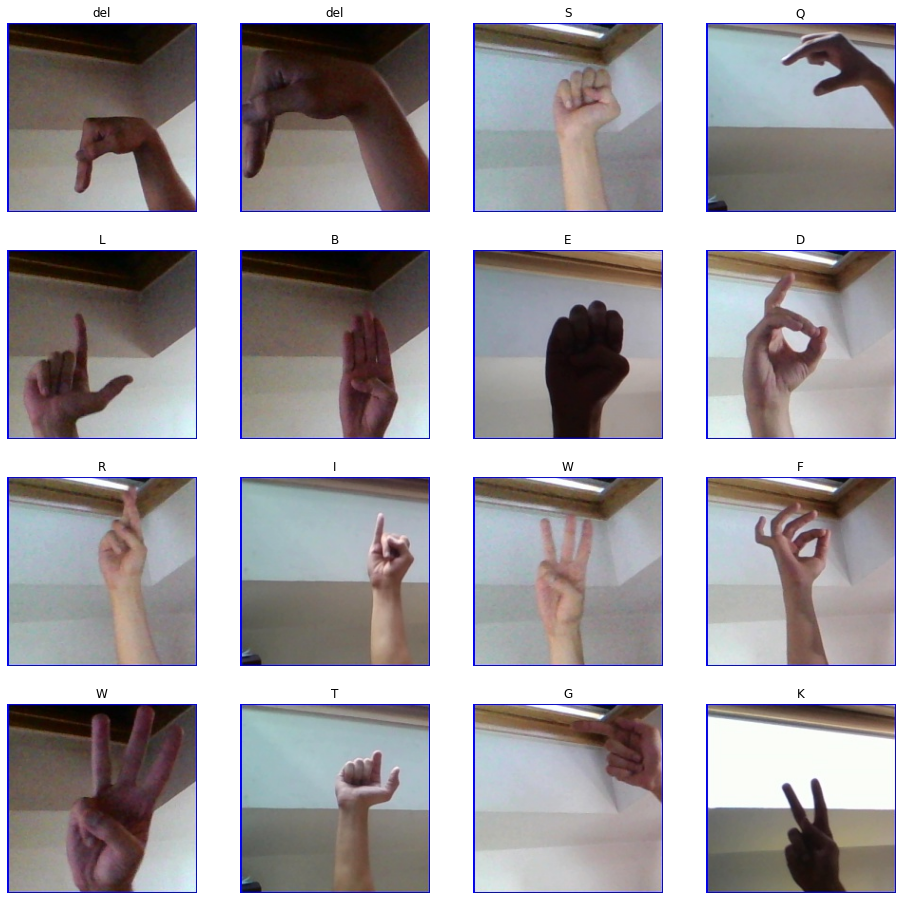

In [6]:
visualize_samples(train_images)

In [7]:
# Neural network architecture

pretrainedModel = tf.keras.applications.MobileNet(
    input_shape=(224, 224, 3),
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
pretrainedModel.trainable = False

inputs = pretrainedModel.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer_adam = tf.keras.optimizers.Adam(learning_rate = 0.005)


2021-11-03 11:12:05.029368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 11:12:05.127649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 11:12:05.128703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 11:12:05.130764: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

17235968/17225924 [==============================] - 0s 0us/step


In [8]:
# Compile model
model.compile(
    optimizer=optimizer_adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
# Fit model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=2,
 )

2021-11-03 11:12:09.614199: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2


2021-11-03 11:12:12.915876: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1110/1110 [==============================] - 1632s 1s/step - loss: 0.2824 - accuracy: 0.9127 - val_loss: 0.1040 - val_accuracy: 0.9649
Epoch 2/2
1110/1110 [==============================] - 1276s 1s/step - loss: 0.1187 - accuracy: 0.9615 - val_loss: 0.0751 - val_accuracy: 0.9745


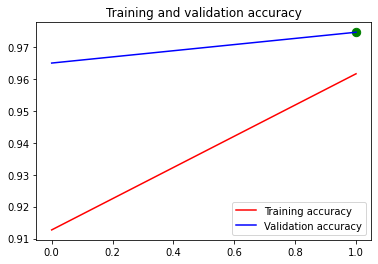

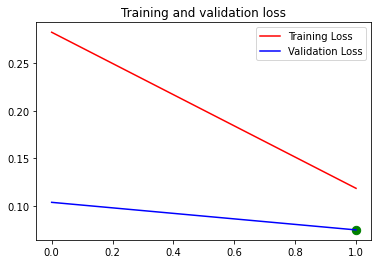

In [10]:
# Training & Validation <> Loss & Accuracy

%matplotlib inline
acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])
loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

epochs = np.arange(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.scatter(epochs[val_acc.argmax()], val_acc.max(), color='green', s=70)
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.scatter(epochs[val_loss.argmin()], val_loss.min(), color='green', s=70)
plt.title('Training and validation loss')
plt.legend()

plt.show()

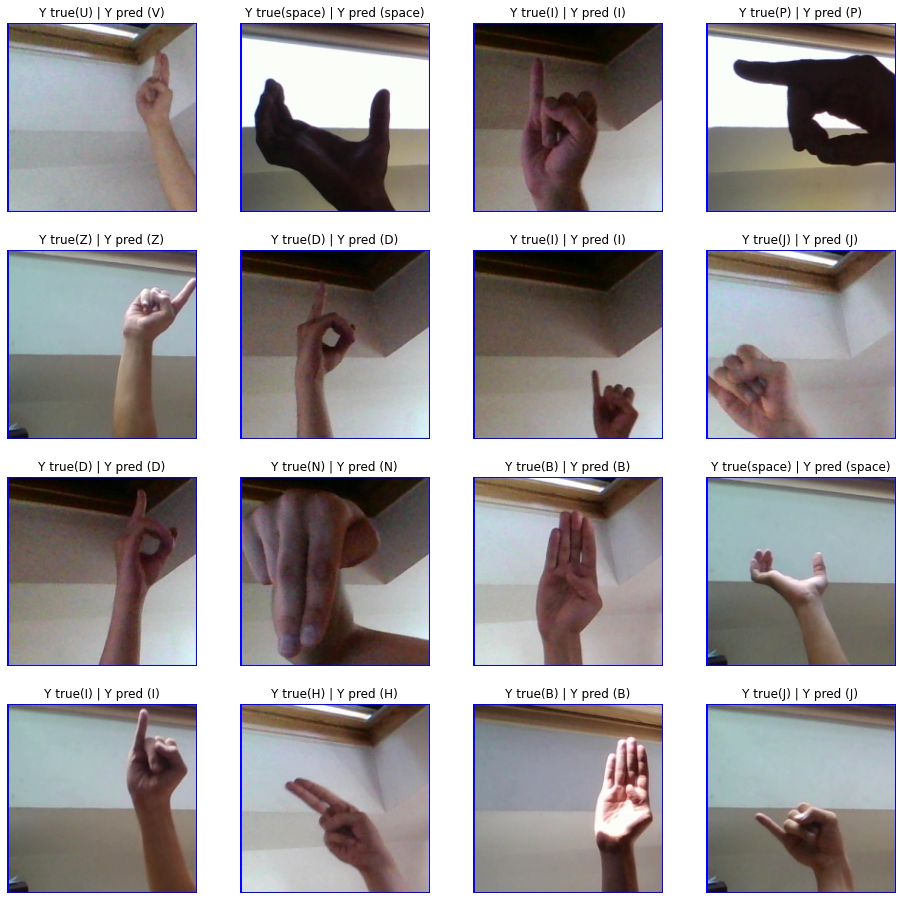

In [11]:
# Visualize classifications on validation set
visualize_classifications(model, val_images)

In [12]:
# Save model
model.save('Sign Language ASL Classifier.h5')

In [13]:
# Save model as a TFLITE (for direct use on Mobile Apps)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('ASL_classifier.tflite', 'wb') as f:
    f.write(tflite_model)

2021-11-03 12:00:51.588739: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-11-03 12:00:59.367710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 12:00:59.368081: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2021-11-03 12:00:59.368224: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-11-03 12:00:59.368728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 12:00:59.369130: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had ne